In [64]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [65]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

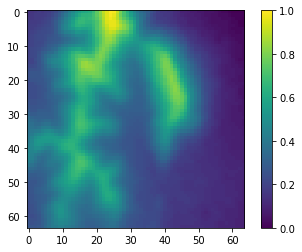

In [66]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[1].view(64, 64))
plt.colorbar(p)
plt.show()

In [67]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [68]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [81]:
vae = VAE().cuda()

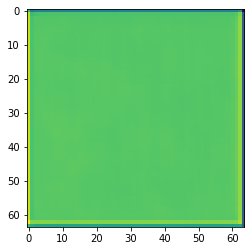

In [82]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [9477]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

vae.train()
epochs = 40

for epoch in range(epochs):
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        data = data.cuda()
        out, mu, logvar = vae(data)
        loss, MSE, KLD = loss_function(out, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
            print(msg)

epoch[1/100], loss=206.470, MSE=199.357, KLD=7.113
epoch[1/100], loss=91.940, MSE=85.759, KLD=6.181
epoch[1/100], loss=64.044, MSE=57.032, KLD=7.012
epoch[1/100], loss=56.923, MSE=50.206, KLD=6.717
epoch[1/100], loss=50.458, MSE=43.398, KLD=7.060
epoch[2/100], loss=42.902, MSE=35.912, KLD=6.990
epoch[2/100], loss=41.175, MSE=34.189, KLD=6.986
epoch[2/100], loss=42.563, MSE=35.879, KLD=6.683
epoch[2/100], loss=37.892, MSE=31.184, KLD=6.708
epoch[2/100], loss=35.635, MSE=29.020, KLD=6.615
epoch[3/100], loss=37.647, MSE=31.296, KLD=6.351
epoch[3/100], loss=33.632, MSE=26.930, KLD=6.703
epoch[3/100], loss=33.081, MSE=26.569, KLD=6.512
epoch[3/100], loss=34.307, MSE=27.681, KLD=6.625
epoch[3/100], loss=32.351, MSE=25.481, KLD=6.870
epoch[4/100], loss=32.823, MSE=26.076, KLD=6.747
epoch[4/100], loss=30.086, MSE=23.729, KLD=6.357
epoch[4/100], loss=31.276, MSE=24.799, KLD=6.477
epoch[4/100], loss=29.900, MSE=23.424, KLD=6.477
epoch[4/100], loss=29.941, MSE=23.109, KLD=6.832
epoch[5/100], loss

epoch[34/100], loss=17.717, MSE=11.354, KLD=6.363
epoch[34/100], loss=18.301, MSE=11.888, KLD=6.414
epoch[34/100], loss=17.682, MSE=11.258, KLD=6.424
epoch[34/100], loss=15.704, MSE=9.497, KLD=6.208
epoch[34/100], loss=19.767, MSE=13.114, KLD=6.654
epoch[35/100], loss=17.630, MSE=11.182, KLD=6.448
epoch[35/100], loss=17.606, MSE=11.120, KLD=6.486
epoch[35/100], loss=16.807, MSE=10.563, KLD=6.244
epoch[35/100], loss=18.253, MSE=11.662, KLD=6.591
epoch[35/100], loss=17.302, MSE=10.815, KLD=6.487
epoch[36/100], loss=17.662, MSE=11.026, KLD=6.636
epoch[36/100], loss=17.531, MSE=11.272, KLD=6.259
epoch[36/100], loss=17.123, MSE=10.767, KLD=6.356
epoch[36/100], loss=18.989, MSE=12.322, KLD=6.668
epoch[36/100], loss=18.526, MSE=11.997, KLD=6.529
epoch[37/100], loss=17.049, MSE=10.661, KLD=6.388
epoch[37/100], loss=17.115, MSE=10.772, KLD=6.344
epoch[37/100], loss=17.912, MSE=11.198, KLD=6.714
epoch[37/100], loss=16.515, MSE=10.134, KLD=6.382
epoch[37/100], loss=17.383, MSE=11.022, KLD=6.361
e

epoch[67/100], loss=16.972, MSE=10.343, KLD=6.628
epoch[67/100], loss=17.682, MSE=10.871, KLD=6.810
epoch[67/100], loss=17.789, MSE=10.800, KLD=6.989
epoch[67/100], loss=18.385, MSE=11.807, KLD=6.578
epoch[67/100], loss=16.503, MSE=9.839, KLD=6.664
epoch[68/100], loss=16.348, MSE=9.609, KLD=6.739
epoch[68/100], loss=16.086, MSE=9.436, KLD=6.650
epoch[68/100], loss=15.962, MSE=9.387, KLD=6.576
epoch[68/100], loss=15.670, MSE=8.976, KLD=6.693
epoch[68/100], loss=18.183, MSE=11.341, KLD=6.842
epoch[69/100], loss=17.252, MSE=10.386, KLD=6.866
epoch[69/100], loss=15.484, MSE=9.130, KLD=6.355
epoch[69/100], loss=17.481, MSE=10.820, KLD=6.661
epoch[69/100], loss=17.445, MSE=10.541, KLD=6.904
epoch[69/100], loss=16.832, MSE=10.099, KLD=6.733
epoch[70/100], loss=16.204, MSE=9.690, KLD=6.514
epoch[70/100], loss=16.205, MSE=9.539, KLD=6.666
epoch[70/100], loss=18.217, MSE=11.383, KLD=6.835
epoch[70/100], loss=17.199, MSE=10.464, KLD=6.735
epoch[70/100], loss=17.244, MSE=10.656, KLD=6.588
epoch[71

epoch[100/100], loss=16.794, MSE=9.849, KLD=6.946
epoch[100/100], loss=16.394, MSE=9.464, KLD=6.930
epoch[100/100], loss=16.692, MSE=9.447, KLD=7.245
epoch[100/100], loss=17.381, MSE=10.316, KLD=7.065


In [9478]:
torch.cuda.empty_cache()

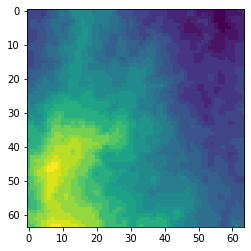

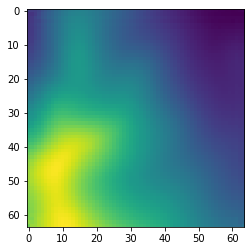

In [84]:
x = dataset[137].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [9481]:
#torch.save(vae.state_dict(), './vae_save')

In [83]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

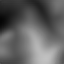

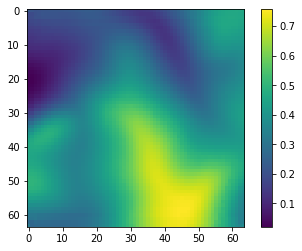

In [418]:
# Generator
code = torch.FloatTensor(1, 64).normal_()
out = vae.decode(code.cuda())
display(transforms.ToPILImage()(out.view(64, 64).cpu()))
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()